<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/NLP%20Course%20-%20Week%203%20Exercise%20Answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 19
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
test_portion=.1

corpus = []


In [2]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)


--2020-09-05 15:45:46--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   120MB/s    in 1.9s    

2020-09-05 15:45:48 (120 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [4]:
print(num_sentences)
print(len(corpus))
print(corpus[1])


1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [5]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

In [6]:
import nltk  
nltk.download('stopwords')
from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer                                 # Python library for NLP
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
def filter_stop_words(train_sentences, stop_words):
    for i, sentence in enumerate(train_sentences):
        new_sent = [stemmer.stem(word) for word in sentence.split() if word not in stop_words]
        train_sentences[i] = ' '.join(new_sent)
    return train_sentences

stop_words = set(stopwords.words("english"))
sentences = filter_stop_words(sentences, stop_words)

In [8]:
import re                                  # library for regular expression operations
for i in range(len(sentences)):
  sentences[i]= re.sub(r'@[A-Za-z0-9_]+', '', sentences[i]) 
  sentences[i] = re.sub(r'https?:\/\/.*[\r\n]*', '', sentences[i])



In [9]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [10]:
print(vocab_size)
print(word_index['i'])

71346
1


In [11]:
import pickle
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [12]:
word_index.items()

dict_items([('i', 1), ('go', 2), ("i'm", 3), ('get', 4), ('day', 5), ('good', 6), ('work', 7), ('like', 8), ('love', 9), ('quot', 10), ('it', 11), ('today', 12), ('time', 13), ('got', 14), ('you', 15), ('lol', 16), ('want', 17), ('back', 18), ('u', 19), ('miss', 20), ('one', 21), ('know', 22), ('think', 23), ('im', 24), ('see', 25), ('feel', 26), ('thank', 27), ('amp', 28), ('realli', 29), ("can't", 30), ('night', 31), ('hope', 32), ('watch', 33), ('need', 34), ('well', 35), ('2', 36), ('still', 37), ('make', 38), ('new', 39), ('now', 40), ('home', 41), ('me', 42), ('oh', 43), ('look', 44), ('come', 45), ('last', 46), ('much', 47), ('wish', 48), ('twitter', 49), ('tomorrow', 50), ('that', 51), ('my', 52), ('3', 53), ('great', 54), ('the', 55), ('haha', 56), ('sleep', 57), ('wait', 58), ('just', 59), ('sad', 60), ('fun', 61), ('right', 62), ('so', 63), ('and', 64), ('bad', 65), ('but', 66), ('week', 67), ('no', 68), ('tri', 69), ('would', 70), ("i'll", 71), ('tonight', 72), ('way', 73),

In [13]:
# Note this is the 100 dimension version of GloVe from Stanford
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-09-05 15:48:46--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   152MB/s    in 2.2s    

2020-09-05 15:48:48 (152 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [14]:
print(len(embeddings_matrix))


71347


In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix],mask_zero=True, trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4)
])
model.add(Bidirectional(LSTM(30, return_sequences = True)))
model.add(Bidirectional(LSTM(30)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 19, 100)           7172800   
_________________________________________________________________
dropout_5 (Dropout)          (None, 19, 100)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 15, 64)            32064     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 3, 60)             22800     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 60)                21840     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
model.save('nlp.h5')

<Figure size 432x288 with 0 Axes>

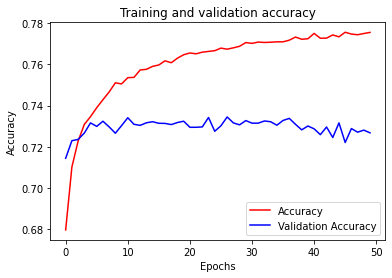

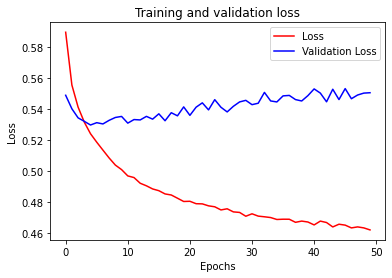

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!